#### 轨迹分析

In [1]:
import scanpy as sc
import omicverse as ov
from omicverse.externel import VIA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ov.plot_set()


2025-07-09 14:04:39.374762: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 14:04:39.380821: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 14:04:39.392677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752069879.412603  391721 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752069879.418317  391721 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/
Dependency error: The 'scrublet>=0.2' distribution was not found and is required by the application


In [2]:
def MergeSubAdata(adata, subAdata, obsName, subObsName):
    obs = pd.Series(list(adata.obs[obsName].copy()), index=adata.obs_names)
    subObs = pd.Series(list(subAdata.obs[subObsName].copy()), index=subAdata.obs_names)
    obs.loc[subObs.index] = subObs
    return pd.DataFrame(obs, columns=[obsName])

def marker(adata, groupby, method='wilcoxon', prefix=''):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby, save=prefix+groupby+'.svg')
    return adata

def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [3]:
adata_epi = sc.read_h5ad('adata-epi-total.h5ad')

Ignoring processing doublet cells...
Evaluating neighbors only...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:52)
running Leiden clustering
    finished: found 17 clusters and added
    'epi-leiden', the cluster labels (adata.obs, categorical) (0:02:13)


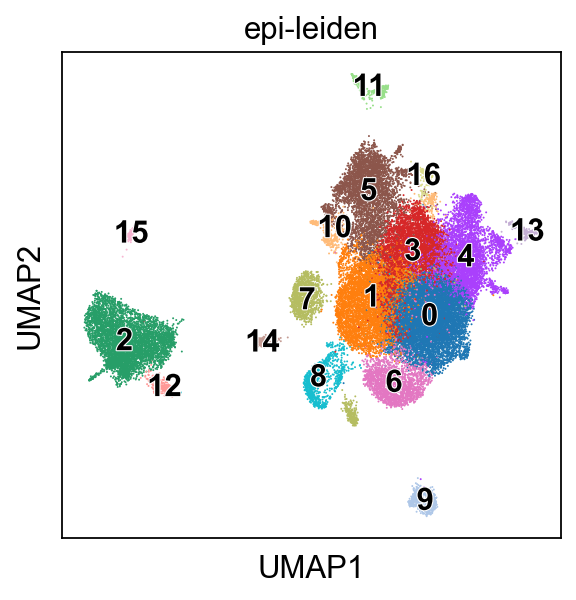

In [4]:
adata_epi = clu(adata_epi, 'epi-leiden', resolution=0.5) 

In [5]:
print(adata_epi.obs['epi-type'].unique())

['TNBC', 'LumHR Normal', 'LumSec Normal', 'Basal', 'HR+HER2-', 'HER2+', 'HR+HER2+']
Categories (7, object): ['Basal', 'HER2+', 'HR+HER2+', 'HR+HER2-', 'LumHR Normal', 'LumSec Normal', 'TNBC']


In [ ]:
sc.tl.paga(adata_epi)
sc.pl.paga(adata_epi, color='treat')

In [18]:
Traj=ov.single.TrajInfer(adata_epi,basis='X_umap',groupby='treat',
                         use_rep='X_pca',n_comps=50,)
Traj.set_origin_cells('Normal')
Traj.inference(method='diffusion_map')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99941164 0.9992567  0.9987275  0.998174   0.9968404
     0.9963766  0.9951436  0.9941649  0.992462   0.9922849  0.99137115
     0.98722106 0.9865539  0.9858752 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:02)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:05:59)
computing Diffusion 

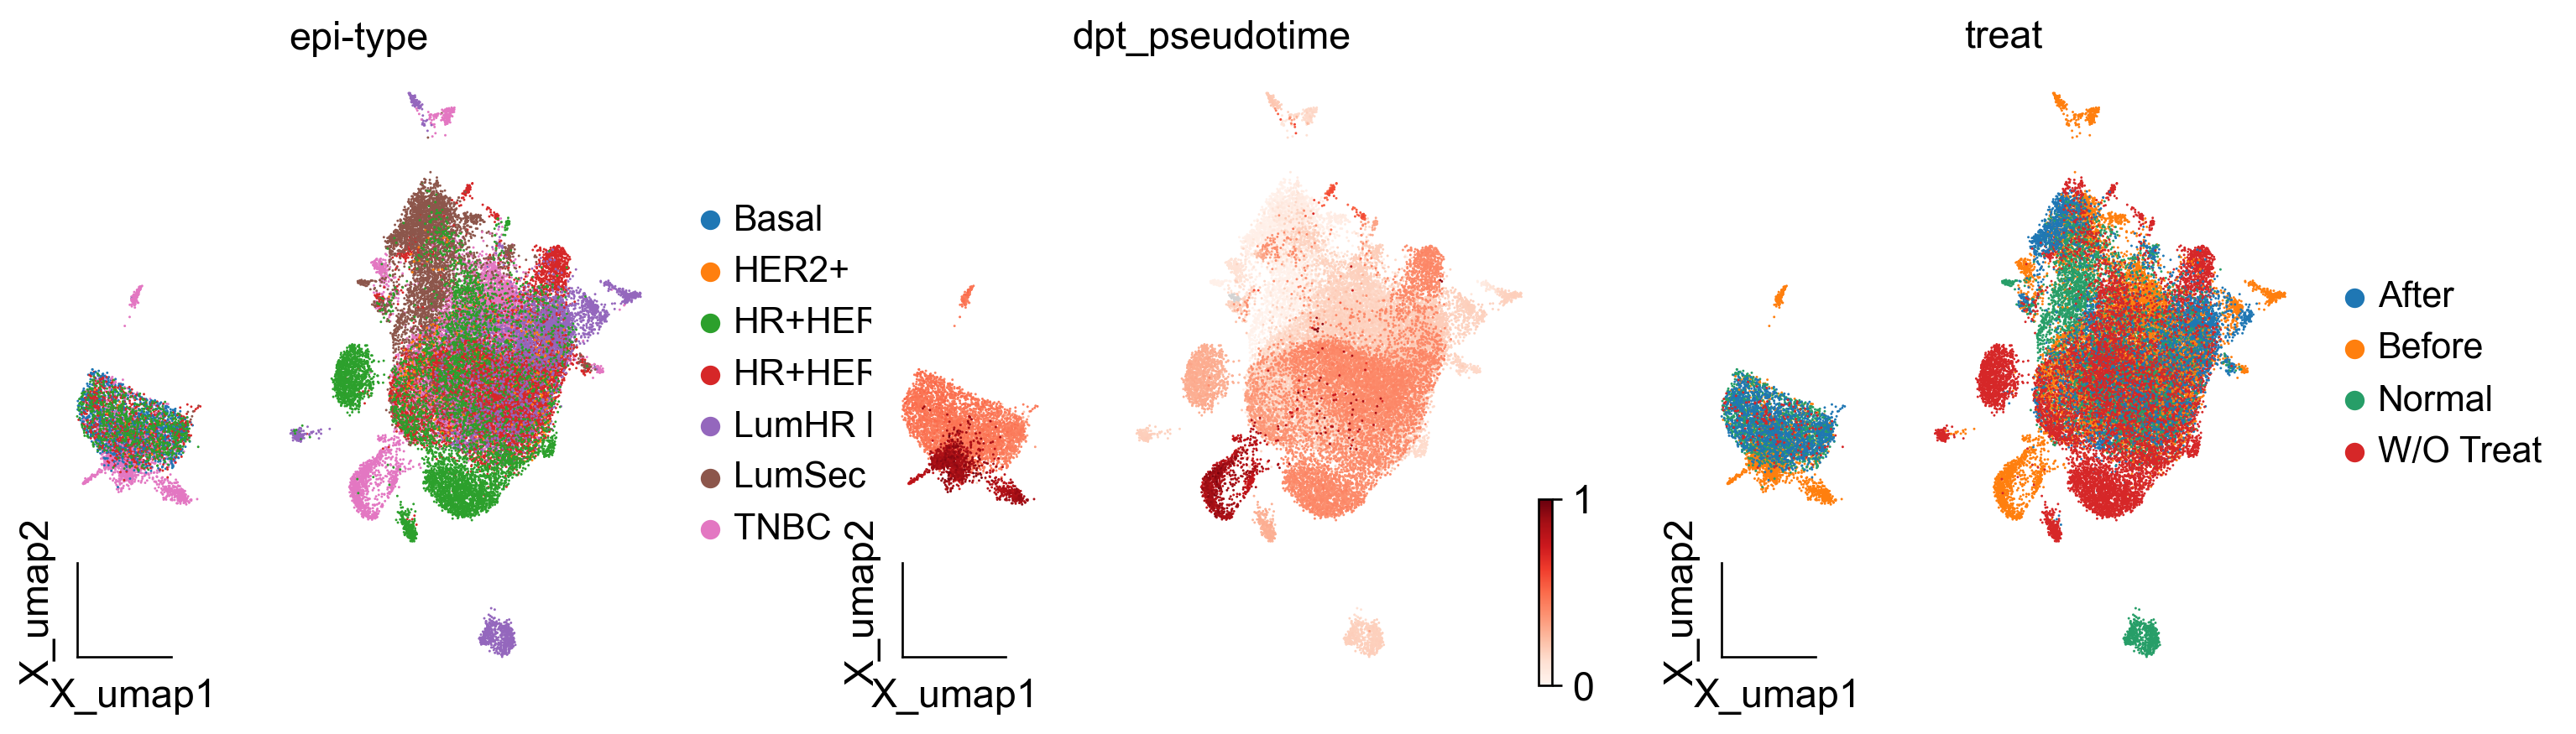

In [19]:
ov.utils.embedding(adata_epi,basis='X_umap',
                   color=['epi-type','dpt_pseudotime', 'treat'],
                   frameon='small',cmap='Reds')

In [21]:
# ncomps=30
# knn=30
# v0_random_seed=4
# root_user = ['Basal'] #属于nIPC细胞类型的一个细胞的索引
# memory = 10
# dataset = ''
# use_rep = 'X_pca'
# clusters = 'epi-type'
# basis='X_umap'

# v0 = VIA.core.VIA(data=adata_epi.obsm[use_rep][:, 0:ncomps], 
#              true_label=adata_epi.obs[clusters], 
#              edgepruning_clustering_resolution=0.15, cluster_graph_pruning=0.15,
#              knn=knn,  root_user=root_user, resolution_parameter=1.5,
#              dataset=dataset, random_seed=v0_random_seed, memory=memory)

# v0.run_VIA()

import pyVIA.core as via
#set parameters for Via 2.0
memory=100 #this is a high memory value and will result in probabilistic pathways that avoid transitioning into unrelated cell populations 
cluster_graph_pruning = 0.15 #level of pruning done on the cluster graph. higher number means less pruning (values can range from 0-3 standard deviations)
edgepruning_clustering_resolution = 0.15  # regulates number of clusters. Higher values means fewer clusters (values can range from 0-3 standard deviations)
random_seed = 42 
knn = 30  # number of neighbors in the knn graph
knn_sequential = 15  # number of neighbors additionally created between sequentially adjacent time points 
n_pcs = 15 # number of principal components
velo_weight = 0  # 0.7 #weight given to velocity based direction compared to pseudotime based direction
t_diff_step = 1 #edges extending between nodes that are more than 2 time steps apart will be removed (i.e. equal to 3 or more time steps apart)
root = ['Normal'] #for reproducibility, we set the root here. the group level root assignment must correspond to a label that exists in the True-label parameter (must be passed inside a list). For autodetection based on rna-velocity it can be left as None. A single cell index can also be passed e.g. [256], means the 256th cell will be used as a root. Since we will be using the velocity matrices (see below), Via 2.0 will suggest a list of likely root cell states that the user can decide to choose between. It is helpful to examine the top 5 suggested roots and choose the one that seems most reasonable. Note in the output that Via 2.0's suggestions are almost all in the epibliast or Primitive streak state 
neighboring_terminal_states_threshold = 4
max_visual_outgoing_edges = 10#5 #used in differentiation flow chart plots
time_series = True
parc_numeric_cluster_labels = [i for i in adata_epi.obs['epi-leiden']]
cluster_celltype_label = [i for i in adata_epi.obs['treat']]
use_velocity = False
velo_weight = 0.5

if use_velocity:
    gene_matrix =np.asmatrix(adata_epi.layers['Ms'])
    velocity_matrix = np.asmatrix(adata_epi.layers['velocity'])
    velo_weight=velo_weight
else: 
    gene_matrix =None
    velocity_matrix = None
    velo_weight=0
v0 = via.VIA(adata_epi.obsm['X_pca'][:, 0:n_pcs], true_label = cluster_celltype_label,
        edgepruning_clustering_resolution=edgepruning_clustering_resolution,
        edgepruning_clustering_resolution_local=1, knn=knn, memory=memory,
        root_user=root, random_seed=random_seed, dataset='group',
        knn_sequential_reverse=knn_sequential,
        )

In [22]:
from datetime import datetime
print(f'{datetime.now()}\tRun Via2.0')
v0.run_VIA()
print(f'{datetime.now()}\tEnd Via2.0 computation')

2025-07-09 13:18:34.679812	Run Via2.0
2025-07-09 13:18:34.680353	Running VIA over input data of 38680 (samples) x 15 (features)
2025-07-09 13:18:34.680407	Knngraph has 30 neighbors
2025-07-09 13:18:46.426899	Finished global pruning of 30-knn graph used for clustering at level of 0.15. Kept 47.7 % of edges. 
2025-07-09 13:18:46.677988	Number of connected components used for clustergraph  is 1
2025-07-09 13:18:49.702100	Commencing community detection
2025-07-09 13:18:53.936831	Finished community detection. Found 283 clusters.
2025-07-09 13:18:53.948447	Merging 239 very small clusters (<10)
2025-07-09 13:18:53.956448	Finished detecting communities. Found 44 communities
2025-07-09 13:18:53.958850	Making cluster graph. Global cluster graph pruning level: 0.15
2025-07-09 13:18:54.142015	Graph has 1 connected components before pruning
2025-07-09 13:18:54.144870	Graph has 2 connected components after pruning
2025-07-09 13:18:54.145989	Graph has 1 connected components after reconnecting
2025-07

2025-07-09 13:19:08.529785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 13:19:08.529967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752067148.549870   56926 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752067148.549958   56927 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752067148.555747   56926 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1752067148.555747   56927 cuda_blas.cc:1

/home/hanxue/miniconda3/envs/omicverse/lib/python3.10/site-packages/phate/__init__.py
/home/hanxue/miniconda3/envs/omicverse/lib/python3.10/site-packages/phate/__init__.py
2025-07-09 13:19:14.892588	Ended all multiprocesses, will retrieve and reshape
2025-07-09 13:19:14.924061	start computing walks with rw2 method


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2025-07-09 13:19:18.782878	Identifying terminal clusters corresponding to unique lineages...
2025-07-09 13:19:18.782905	Closeness:[13, 18, 38, 41]
2025-07-09 13:19:18.782915	Betweenness:[2, 3, 4, 5, 8, 10, 12, 13, 14, 19, 22, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 38, 39, 40, 41]
2025-07-09 13:19:18.782925	Out Degree:[2, 3, 8, 10, 11, 13, 14, 15, 18, 21, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41]
2025-07-09 13:19:18.783304	Terminal clusters corresponding to unique lineages in this component are [33, 34, 3, 35, 38, 39, 8, 41, 10, 13, 14, 18, 26, 27, 28] 
2025-07-09 13:19:18.783324	Calculating lineage probability at memory 100


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-07-09 13:19:22.413992	Cluster or terminal cell fate 33 is reached 35.0 times
2025-07-09 13:19:22.477342	Cluster or terminal cell fate 34 is reached 118.0 times
2025-07-09 13:19:22.540145	Cluster or terminal cell fate 3 is reached 48.0 times
2025-07-09 13:19:22.603543	Cluster or terminal cell fate 35 is reached 3.0 times
2025-07-09 13:19:22.670484	38 cluster/state is never reached. try increase number of KNN (which will increase number of edges) or try to increase the value of jac_std_global and cluster_graph_pruning which will lower edge pruning
2025-07-09 13:19:22.734421	Cluster or terminal cell fate 39 is reached 8.0 times
2025-07-09 13:19:22.798008	Cluster or terminal cell fate 8 is reached 8.0 times
2025-07-09 13:19:22.861310	41 cluster/state is never reached. try increase number of KNN (which will increase number of edges) or try to increase the value of jac_std_global and cluster_graph_pruning which will lower edge pruning
2025-07-09 13:19:22.927826	Cluster or terminal cell 

2025-07-09 13:20:22.693920	Plot Via2.0 cluster graph
tune edges False


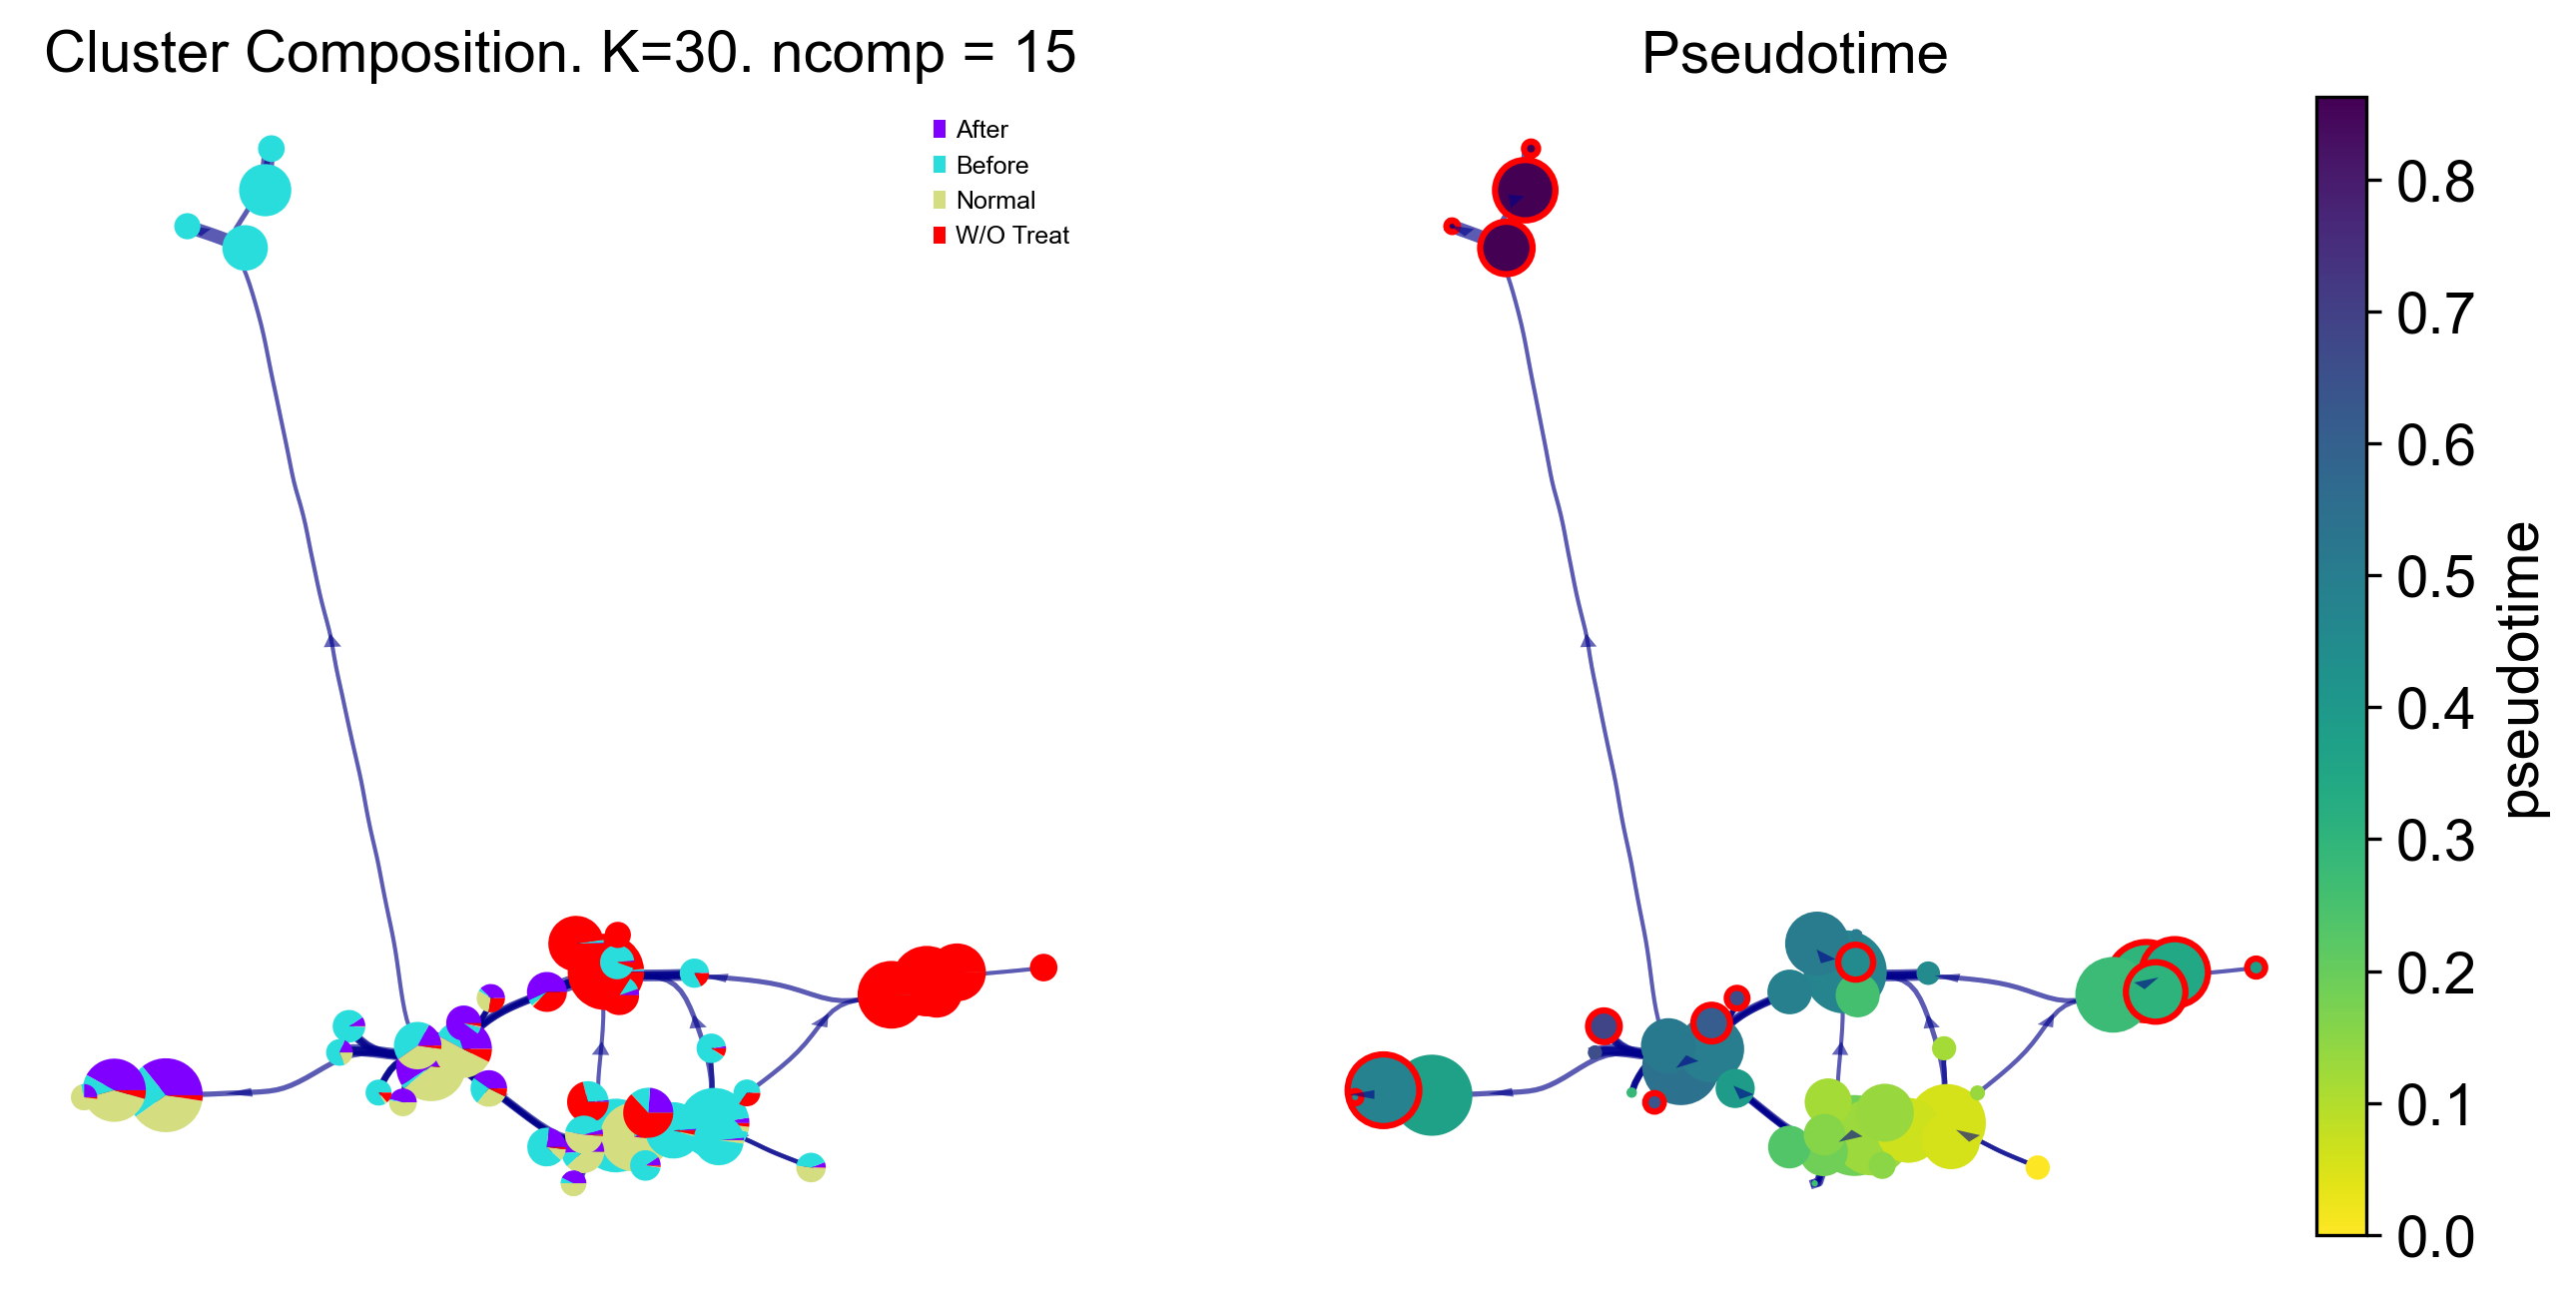

In [23]:
# f, ax, ax1=VIA.core.plot_piechart_viagraph_ov(adata_epi,clusters='treat', via_object=v0, headwidth_arrow=0.4, show_legend=True, ax_text=False, pie_size_scale=0.6, cmap_piechart='rainbow', 
#                         highlight_terminal_clusters=True, size_node_notpiechart=0.8)
# f.set_size_inches(10, 5)
# f.savefig(f'figures/epi-treat-trajectory.svg')

print(f'{datetime.now()}\tPlot Via2.0 cluster graph')

# f, ax, ax1=via.plot_piechart_viagraph(via_object=v0, cmap_piechart='viridis_r', cmap='viridis_r',  reference_labels=cluster_celltype_label, headwidth_arrow=0.4,
#                         highlight_terminal_clusters=True, show_legend=True)
# f.set_size_inches(10, 5)
age_label = [i for i in adata_epi.obs['treat']]
f, ax, ax1=via.plot_piechart_viagraph(via_object=v0, headwidth_arrow=0.4, show_legend=True, ax_text=False, pie_size_scale=0.6, cmap_piechart='rainbow', 
                        highlight_terminal_clusters=True, size_node_notpiechart=0.8)
f.set_size_inches(10, 5)
f.savefig(f'figures/epi-total-trajectory.svg')
# f, ax, ax1= via.plot_piechart_viagraph(via_object=v0, cmap_piechart='jet', cmap='plasma',
#                         reference_labels=cluster_celltype_label, headwidth_arrow=0.4,
#                         highlight_terminal_clusters=True,size_node_notpiechart=0.8)
# f.set_size_inches(10, 5)

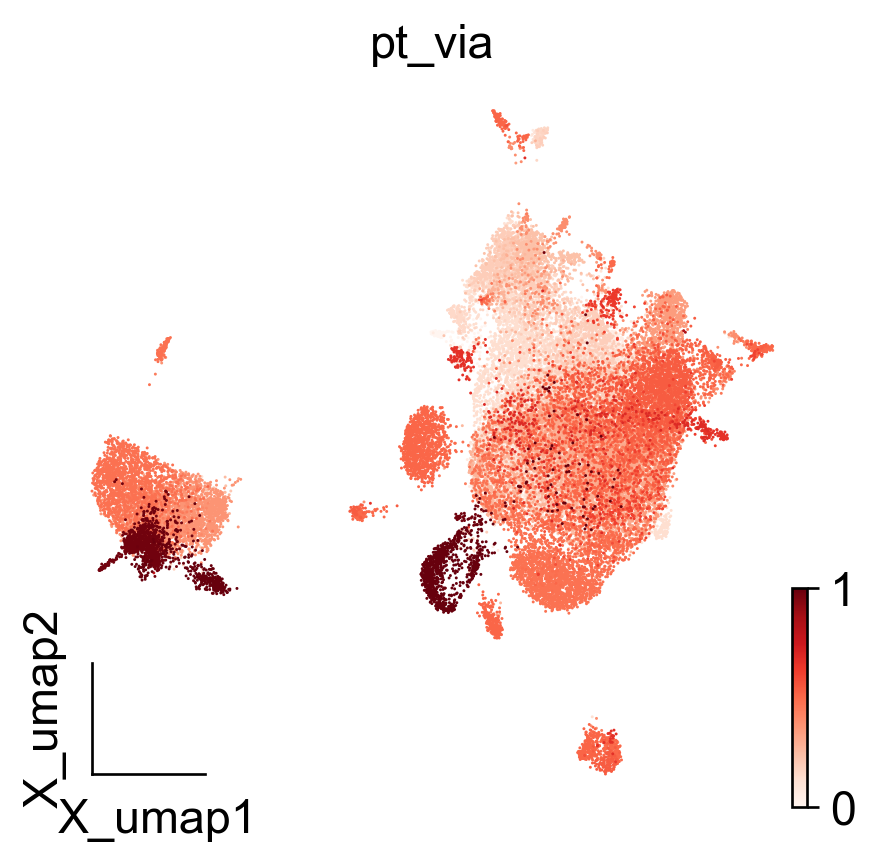

In [24]:
adata_epi.obs['pt_via']=v0.single_cell_pt_markov
ov.pl.embedding(adata_epi,basis='X_umap',
                   color=['pt_via'],
                   frameon='small',cmap='Reds')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

2025-07-09 13:22:09.495003	Start Atlas embedding computation
2025-07-09 13:22:09.495536	Plot Atlas Embedding


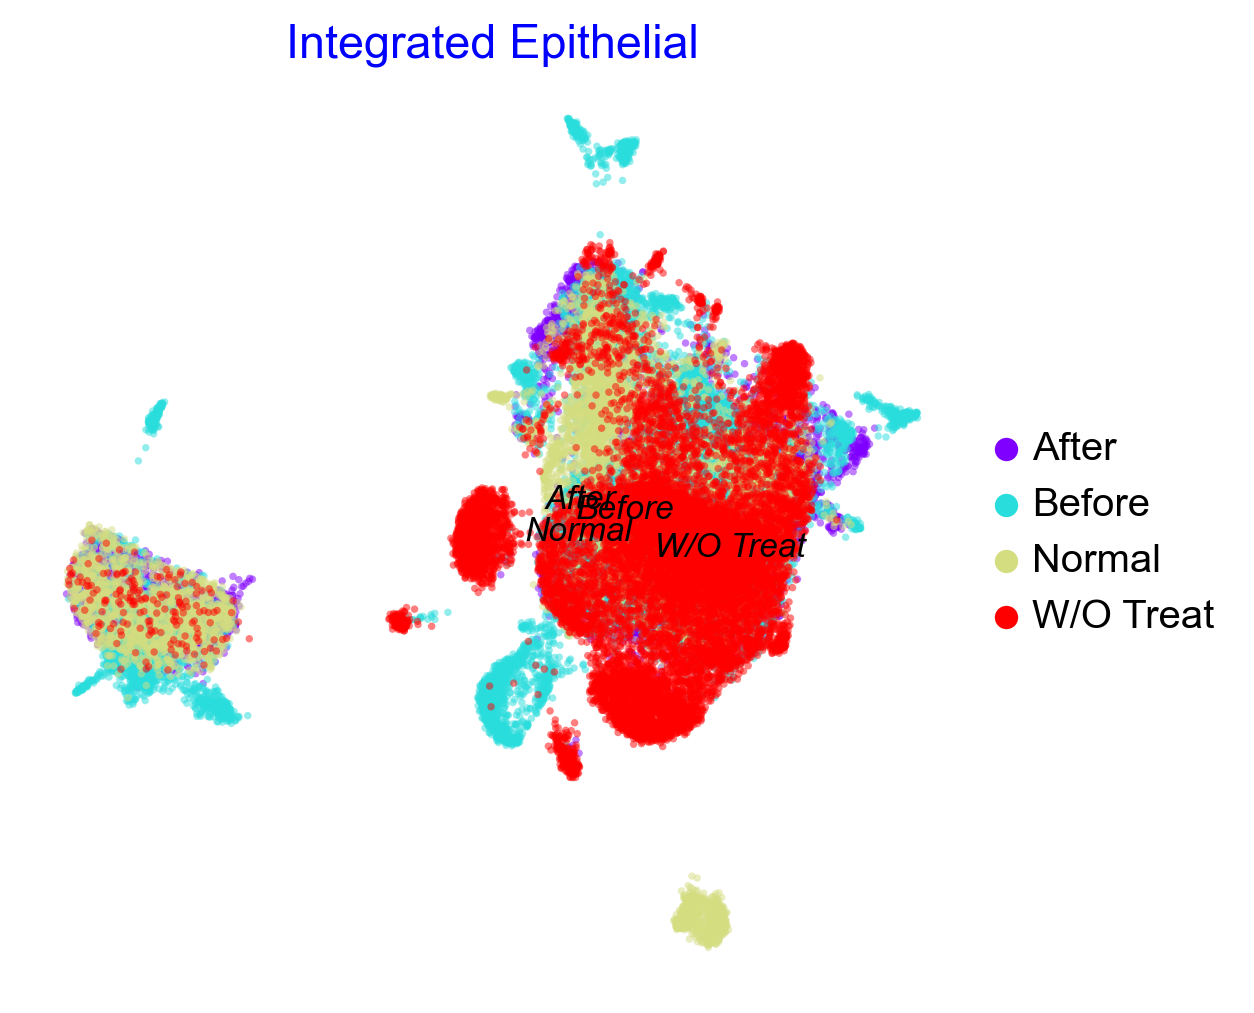

In [25]:
print(f'{datetime.now()}\tStart Atlas embedding computation')
# compute_atlas_embedding = True
# if compute_atlas_embedding:
#     atlas_embedding = via.via_atlas_emb(via_object=v0, init_pos='via', min_dist=0.2, n_components=3)
# else: atlas_embedding = adata_concat.obsm['X_umap']
atlas_embedding = adata_epi.obsm['X_umap']

print(f'{datetime.now()}\tPlot Atlas Embedding')
# f1, ax = via.plot_scatter(embedding=atlas_embedding, labels=parc_numeric_cluster_labels, cmap='plasma', s=5,
#                           alpha=0.5, edgecolors='None',
#                           title='atlas', text_labels=False)
# f1.set_size_inches(10, 10)

f2, ax = via.plot_scatter(embedding=atlas_embedding, labels=cluster_celltype_label, title='Integrated Epithelial',
                          alpha=0.5, s=5)
f2.set_size_inches(5, 5)
f2.savefig("figures/3j.svg")

head df full          pt celltype
0  1.000000   Before
1  0.979946   Before
2  0.676662   Before
3  1.000000   Before
4  1.000000   Before
dict temp Counter({'Normal': 0.51010101010101, 'Before': 0.4292929292929293, 'After': 0.05555555555555555, 'W/O Treat': 0.005050505050505051})
dict temp Counter({'Before': 0.9432258064516129, 'W/O Treat': 0.02129032258064516, 'Normal': 0.01870967741935484, 'After': 0.016774193548387096})
dict temp Counter({'Normal': 0.3644904842206697, 'W/O Treat': 0.3020958805107203, 'Before': 0.22139243555769694, 'After': 0.11202119971091304})
dict temp Counter({'Before': 0.7012987012987013, 'Normal': 0.14779220779220778, 'After': 0.12597402597402596, 'W/O Treat': 0.024935064935064935})
dict temp Counter({'Before': 0.6433990895295902, 'After': 0.2094081942336874, 'Normal': 0.10925644916540213, 'W/O Treat': 0.03793626707132018})
dict temp Counter({'W/O Treat': 0.9495798319327731, 'Before': 0.031786627694556084, 'After': 0.014979905005480453, 'Normal': 0.00365363536

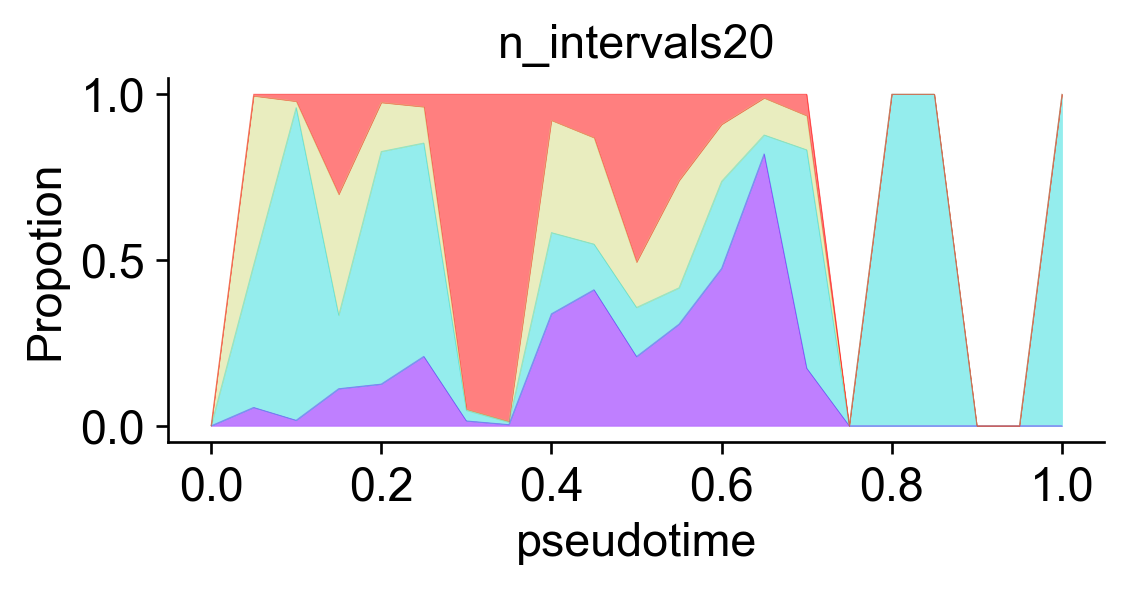

In [26]:
ax = via.plot_population_composition(v0, xlabel='pseudotime', ylabel='Propotion', legend=False,  title='', cmap='rainbow', n_intervals=20)
ax.figure.set_size_inches(5, 2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.figure.savefig('figures/3l.svg')

In [4]:
adata_epi_after = adata_epi[adata_epi.obs['treat'].isin(["After"]), :]

In [5]:
adata_epi_after.obs['effect'] = 'better'
adata_epi_after.obs.loc[adata_epi_after.obs['batch'].isin(['13T', '19T']),'effect'] = 'better'
adata_epi_after.obs.loc[adata_epi_after.obs['batch'].isin(['11T', '12T', '16T']),'effect'] = 'worse'

Ignoring processing doublet cells...
Evaluating neighbors only...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)
running Leiden clustering
    finished: found 7 clusters and added
    'epi-leiden-after', the cluster labels (adata.obs, categorical) (0:00:10)


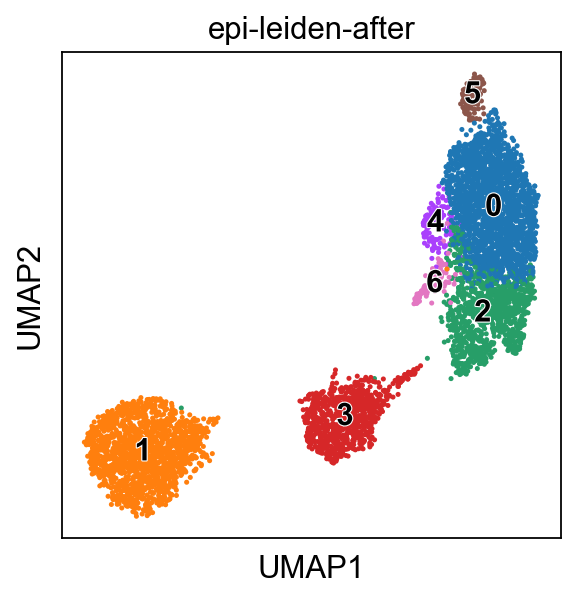

In [6]:
adata_epi_after = clu(adata_epi_after, 'epi-leiden-after', resolution=0.5) 

In [7]:
Traj=ov.single.TrajInfer(adata_epi_after,basis='X_umap',groupby='epi-type',
                         use_rep='X_pca',n_comps=50,)
Traj.set_origin_cells('Basal')
Traj.inference(method='diffusion_map')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99857336 0.9951261  0.9917738  0.99017066 0.9891608
     0.9838781  0.9702603  0.9643835  0.9595075  0.9528788  0.9516294
     0.9509001  0.9359667  0.92866415]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:39)
computing Diffusion P

In [9]:
import pyVIA.core as via
#set parameters for Via 2.0
memory=100 #this is a high memory value and will result in probabilistic pathways that avoid transitioning into unrelated cell populations 
cluster_graph_pruning = 0.15 #level of pruning done on the cluster graph. higher number means less pruning (values can range from 0-3 standard deviations)
edgepruning_clustering_resolution = 0.15  # regulates number of clusters. Higher values means fewer clusters (values can range from 0-3 standard deviations)
random_seed = 42 
knn = 30  # number of neighbors in the knn graph
knn_sequential = 15  # number of neighbors additionally created between sequentially adjacent time points 
n_pcs = 15 # number of principal components
velo_weight = 0  # 0.7 #weight given to velocity based direction compared to pseudotime based direction
t_diff_step = 1 #edges extending between nodes that are more than 2 time steps apart will be removed (i.e. equal to 3 or more time steps apart)
root = ['Basal'] #for reproducibility, we set the root here. the group level root assignment must correspond to a label that exists in the True-label parameter (must be passed inside a list). For autodetection based on rna-velocity it can be left as None. A single cell index can also be passed e.g. [256], means the 256th cell will be used as a root. Since we will be using the velocity matrices (see below), Via 2.0 will suggest a list of likely root cell states that the user can decide to choose between. It is helpful to examine the top 5 suggested roots and choose the one that seems most reasonable. Note in the output that Via 2.0's suggestions are almost all in the epibliast or Primitive streak state 
neighboring_terminal_states_threshold = 4
max_visual_outgoing_edges = 10#5 #used in differentiation flow chart plots
time_series = True
parc_numeric_cluster_labels = [i for i in adata_epi_after.obs['epi-leiden-after']]
cluster_celltype_label = [i for i in adata_epi_after.obs['epi-type']]
use_velocity = False
velo_weight = 0.5

if use_velocity:
    gene_matrix =np.asmatrix(adata_epi_after.layers['Ms'])
    velocity_matrix = np.asmatrix(adata_epi_after.layers['velocity'])
    velo_weight=velo_weight
else: 
    gene_matrix =None
    velocity_matrix = None
    velo_weight=0
v0 = via.VIA(adata_epi_after.obsm['X_pca'][:, 0:n_pcs], true_label = cluster_celltype_label,
        edgepruning_clustering_resolution=edgepruning_clustering_resolution,
        edgepruning_clustering_resolution_local=1, knn=knn, memory=memory,
        root_user=root, random_seed=random_seed, dataset='group',
        knn_sequential_reverse=knn_sequential,
        )

In [13]:
from datetime import datetime
print(f'{datetime.now()}\tRun Via2.0')
v0.run_VIA()
print(f'{datetime.now()}\tEnd Via2.0 computation')

2025-07-09 14:12:01.907396	Run Via2.0
2025-07-09 14:12:01.907478	Running VIA over input data of 5795 (samples) x 15 (features)
2025-07-09 14:12:01.907494	Knngraph has 30 neighbors
2025-07-09 14:12:05.083751	Finished global pruning of 30-knn graph used for clustering at level of 0.15. Kept 48.3 % of edges. 
2025-07-09 14:12:05.116941	Number of connected components used for clustergraph  is 1
2025-07-09 14:12:05.468165	Commencing community detection
2025-07-09 14:12:06.036443	Finished community detection. Found 70 clusters.
2025-07-09 14:12:06.038567	Merging 44 very small clusters (<10)
2025-07-09 14:12:06.040435	Finished detecting communities. Found 26 communities
2025-07-09 14:12:06.040820	Making cluster graph. Global cluster graph pruning level: 0.15
2025-07-09 14:12:06.062560	Graph has 1 connected components before pruning
2025-07-09 14:12:06.064471	Graph has 2 connected components after pruning
2025-07-09 14:12:06.065516	Graph has 1 connected components after reconnecting
2025-07-09

2025-07-09 14:12:18.725171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 14:12:18.733818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752070338.745157  432775 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752070338.750943  432775 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1752070338.753645  432774 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752070338.759364  432774 cuda_blas.cc:1

/home/hanxue/miniconda3/envs/omicverse/lib/python3.10/site-packages/phate/__init__.py
/home/hanxue/miniconda3/envs/omicverse/lib/python3.10/site-packages/phate/__init__.py
2025-07-09 14:12:25.420648	Ended all multiprocesses, will retrieve and reshape
2025-07-09 14:12:25.462141	start computing walks with rw2 method


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2025-07-09 14:12:33.276366	Identifying terminal clusters corresponding to unique lineages...
2025-07-09 14:12:33.276393	Closeness:[1, 2, 3, 6, 7, 10, 11, 14, 15, 17, 20, 21, 24]
2025-07-09 14:12:33.276405	Betweenness:[1, 2, 3, 6, 9, 11, 13, 14, 15, 17, 20, 21, 23, 24]
2025-07-09 14:12:33.276414	Out Degree:[1, 6, 7, 11, 14, 15, 16, 17, 18, 20, 21, 22, 24]
2025-07-09 14:12:33.276591	Cluster 1 had 3 or more neighboring terminal states [7, 11, 14, 17] and so we removed cluster 7
2025-07-09 14:12:33.276653	Cluster 14 had 3 or more neighboring terminal states [1, 11, 17] and so we removed cluster 1
2025-07-09 14:12:33.276826	Terminal clusters corresponding to unique lineages in this component are [2, 6, 11, 14, 15, 17, 20, 21, 24] 
2025-07-09 14:12:33.276845	Calculating lineage probability at memory 100


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-07-09 14:12:37.592259	Cluster or terminal cell fate 2 is reached 265.0 times
2025-07-09 14:12:37.633495	6 cluster/state is never reached. try increase number of KNN (which will increase number of edges) or try to increase the value of jac_std_global and cluster_graph_pruning which will lower edge pruning
2025-07-09 14:12:37.673755	Cluster or terminal cell fate 11 is reached 209.0 times
2025-07-09 14:12:37.713355	Cluster or terminal cell fate 14 is reached 287.0 times
2025-07-09 14:12:37.750502	Cluster or terminal cell fate 15 is reached 322.0 times
2025-07-09 14:12:37.789967	Cluster or terminal cell fate 17 is reached 250.0 times
2025-07-09 14:12:37.831976	Cluster or terminal cell fate 20 is reached 3.0 times
2025-07-09 14:12:37.873194	Cluster or terminal cell fate 21 is reached 3.0 times
2025-07-09 14:12:37.911347	Cluster or terminal cell fate 24 is reached 262.0 times
2025-07-09 14:12:37.926499	There are (9) terminal clusters corresponding to unique lineages {2: 'HR+HER2-', 6: '

tune edges False


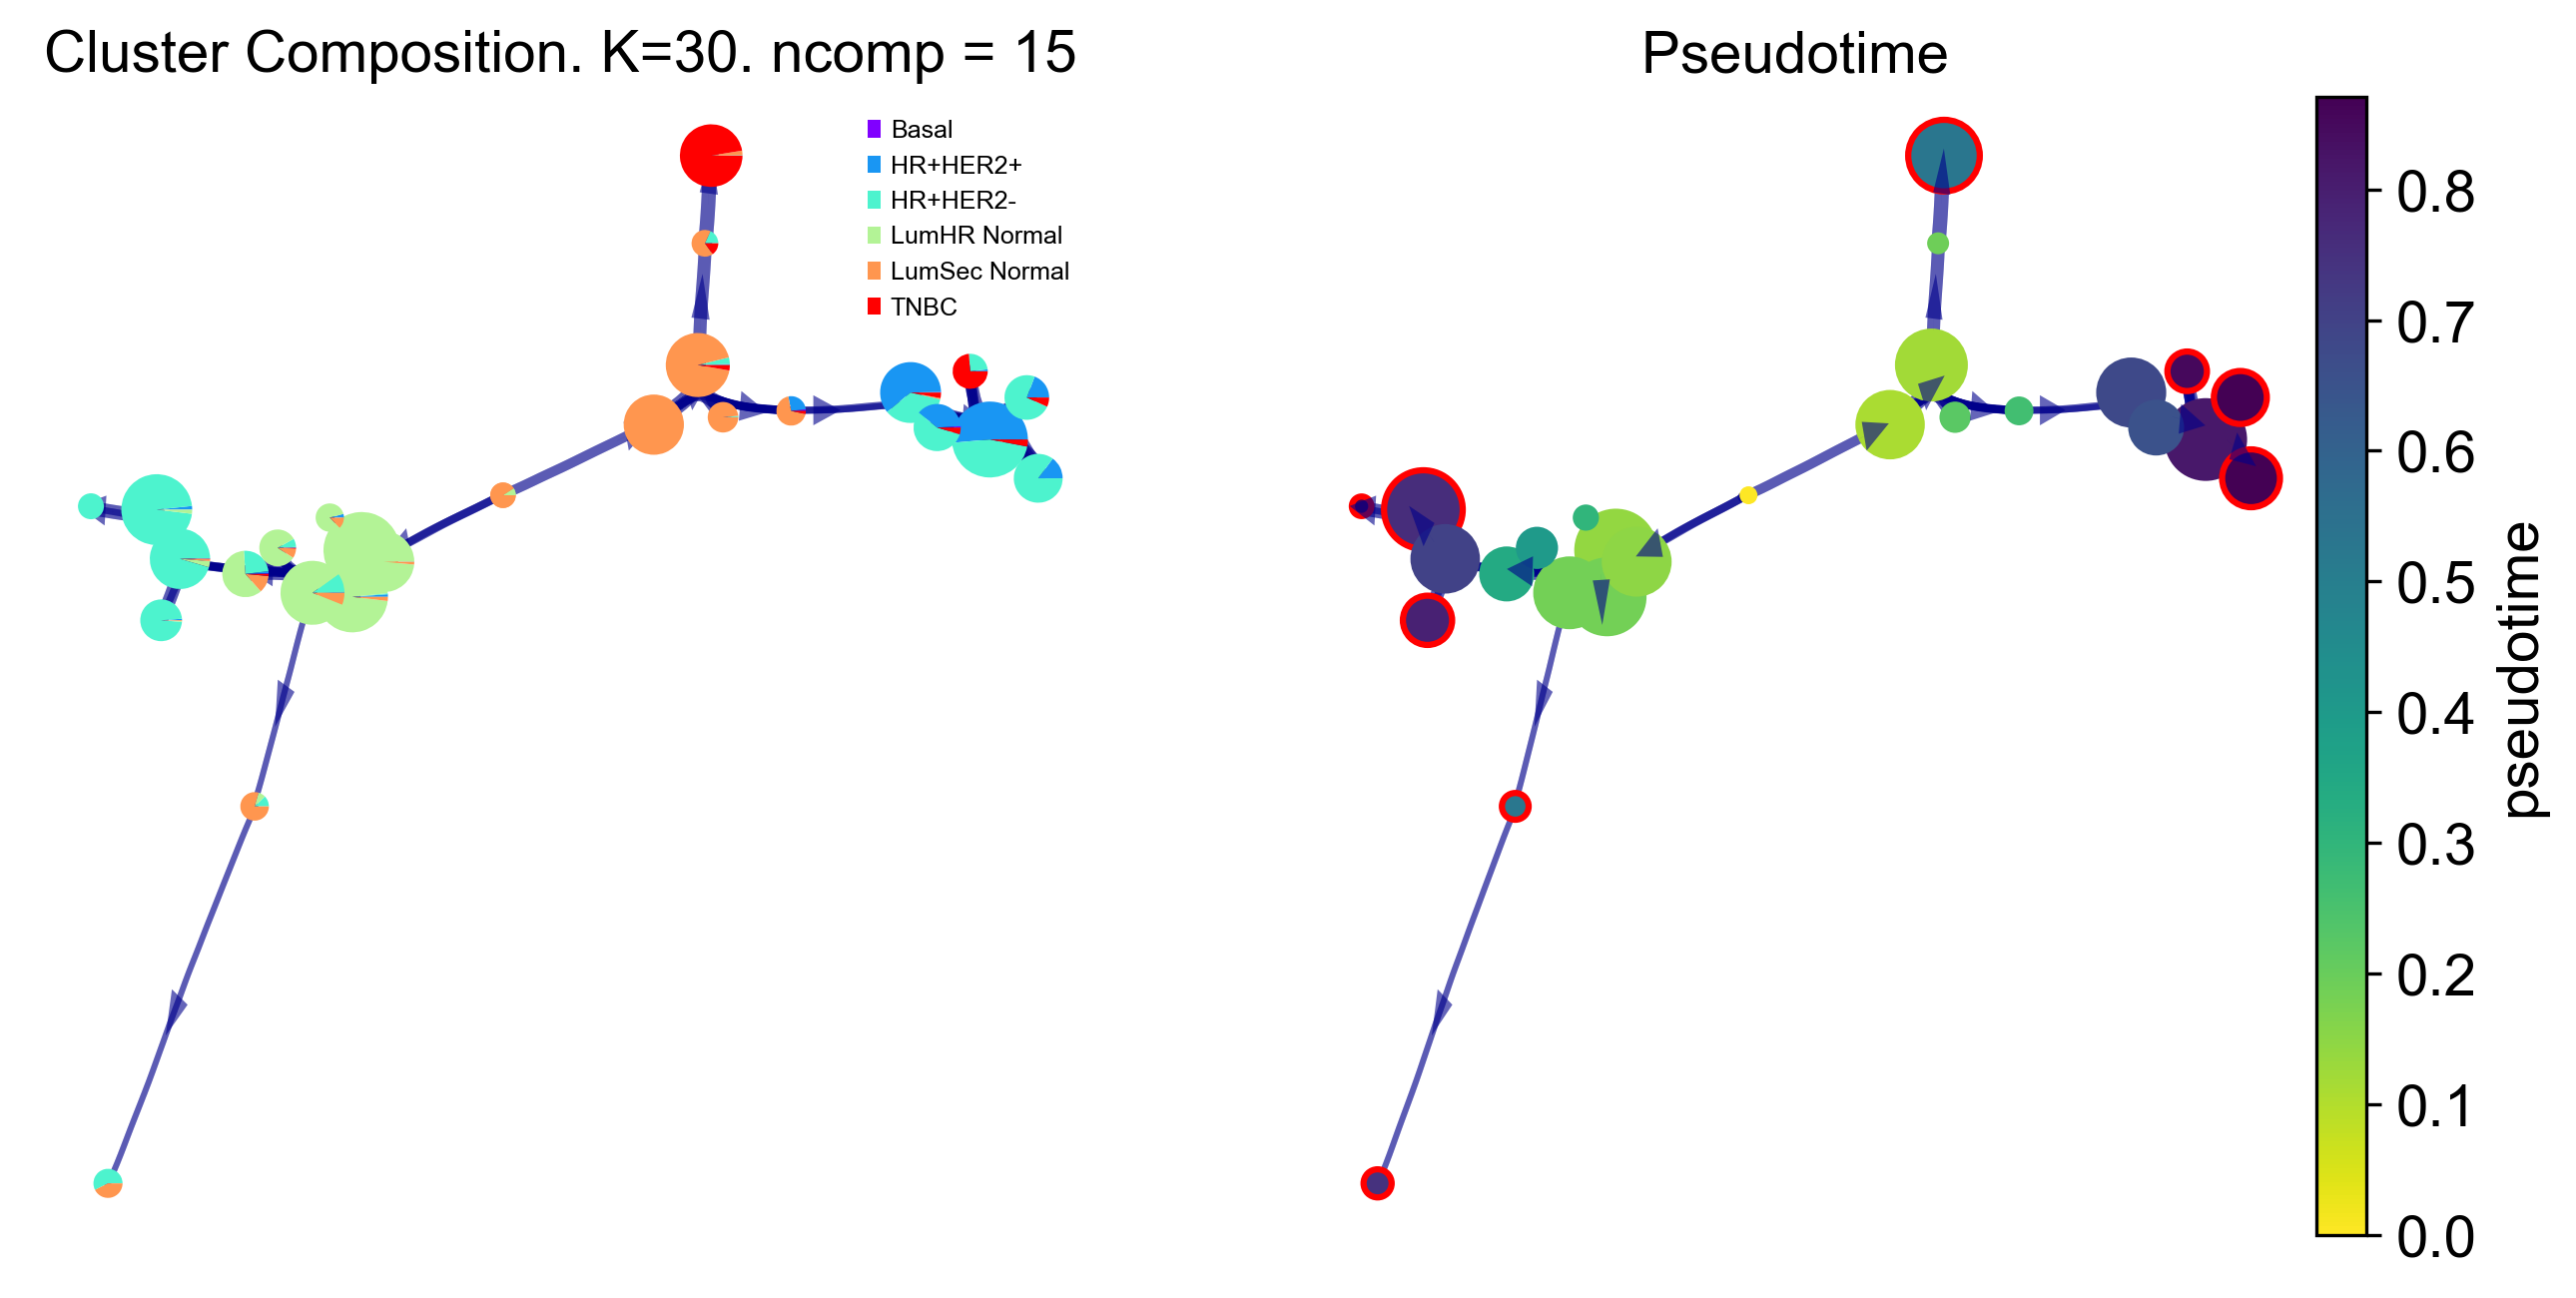

In [ ]:
# f, ax, ax1=via.plot_piechart_viagraph(via_object=v0, cmap_piechart='viridis_r', cmap='viridis_r',  reference_labels=cluster_celltype_label, headwidth_arrow=0.4,
#                         highlight_terminal_clusters=True, show_legend=True)
# f.set_size_inches(10, 5)
f, ax, ax1=via.plot_piechart_viagraph(via_object=v0, headwidth_arrow=0.4, show_legend=True, ax_text=False, pie_size_scale=0.6, cmap_piechart='rainbow', 
                        highlight_terminal_clusters=True, size_node_notpiechart=0.8)
f.set_size_inches(10, 5)
f.savefig(f'figures/epi-after-trajectory.svg')